In [187]:
import numpy as np
import pandas as pd
import time
import heapq
import copy
import matplotlib.pyplot as plt

Understanding the distributions

In [188]:
df = pd.read_excel("data.xls")

In [189]:
arrivalTimingsSec = df["Arrival time (sec)"].values
baseStations = df["Base station "].values
callDurationsSec = df["Call duration (sec)"].to_numpy()
velocitiesKmHr = df["velocity (km/h)"].to_numpy()

Converting data to required units

In [190]:
# Inter-arrival Seconds to milliseconds
interArrivalTimingsSec = np.diff(arrivalTimingsSec)
interArrivalTimingsMs = interArrivalTimingsSec * 1000.0

# Call duration Seconds to milliseconds
callDurationsMs = callDurationsSec * 1000.0

# Velocity km/hr to cm/ms
velocitiesCmHr = velocitiesKmHr * 1000.0 * 100.0
velocitiesCmMs = velocitiesCmHr / 60.0 / 60.0 / 1000.0

Creating Distribution

In [191]:
rndGenerator = np.random.default_rng()

def genInitiationTime():
    return rndGenerator.exponential(interArrivalTimingsMs.mean())

def genCallDuration():
    return rndGenerator.exponential(callDurationsMs.mean())

def genCarVelocity():
    return rndGenerator.normal(velocitiesCmMs.mean(), velocitiesCmMs.std())

def genCarPosition():
    return rndGenerator.integers(200001)

def genBaseStation():
    return rndGenerator.integers(20)

def genCarDirection():
    return rndGenerator.integers(2)

print("inter-arrival:", genInitiationTime())
print("call duration:", genCallDuration())
print("car velocity:", genCarVelocity())
print("car position:", genCarPosition())
print("base station:", genBaseStation())
print("car direction:", genCarDirection())

inter-arrival: 1468.8749461022937
call duration: 492938.5085238192
car velocity: 2.6914702280821388
car position: 174414
base station: 19
car direction: 0


System Variables required to run the model

State Variables to represent the Model

Simulation Variables

Class for all the data

In [192]:
class SimulationData:
    def __init__(self, numOfChannels, resHandoverCh, simulationLength, warmupPerc) -> None:
        self.setNumOfChannels(numOfChannels)
        self.setResHandoverCh(resHandoverCh)
        self.setSimulationLength(simulationLength)
        self.setWarmupPerc(warmupPerc)
        self.systemData = SystemData()
        self.stateData = StateData(self)

    def setNumOfChannels(self, numOfChannels):
        self.__numOfChannels = numOfChannels # Number of channels in a base station
        self.numOfChannels = self.__numOfChannels
    
    def setResHandoverCh(self, resHandoverCh):
        self.__resHandoverCh = resHandoverCh # Number of reserved handover channels
        self.resHandoverCh = self.__resHandoverCh

    def setSimulationLength(self, simulationLength):
        self.__simulationLength = simulationLength # 9223372036854775807
        self.simulationLength = self.__simulationLength

    def setWarmupPerc(self, warmupPerc):
        self.__warmupPerc = warmupPerc # Out of 100 percent
        self.warmupPeriod = self.simulationLength*self.__warmupPerc/100.0

    def reset(self):
        self.numOfChannels = self.__numOfChannels
        self.resHandoverCh = self.__resHandoverCh
        self.simulationLength = self.__simulationLength
        self.warmupPeriod = self.simulationLength*self.__warmupPerc/100.0
        self.systemData.reset()
        self.stateData.reset()

class SystemData:
    def __init__(self) -> None:
        self.startClock = time.time()
        self.endClock = time.time()
        self.simClock = 0
        self.FEL = []
        self.warmupEnd = False

    def pushEvent(self, time, event):
        heapq.heappush(self.FEL, (time, event))
    
    def popEvent(self):
        return heapq.heappop(self.FEL)

    def reset(self):
        self.startClock = time.time()
        self.endClock = time.time()
        self.simClock = 0
        self.FEL = []
        self.warmupEnd = False

class StateData:
    def __init__(self, simData) -> None:
        self.simData = simData
        self.baseStations = [simData.numOfChannels]*20

    def reset(self):
        self.baseStations = [self.simData.numOfChannels]*20

Statistical Counters

In [193]:
class StatisticRecorder:
    def __init__(self, simData:SimulationData) -> None:
        self.simData = simData
        self.bCalls = 0
        self.dCalls = 0
        self.tCalls = 0
        self.cCalls = 0
        self.history = []
        self.historyList = []
        self.records = []

    def reset(self):
        self.bCalls = 0
        self.dCalls = 0
        self.tCalls = 0
        self.cCalls = 0

    def add(self, b, d, t, c, log):
        if log:
            self.bCalls += b
            self.dCalls += d
            self.tCalls += t
            self.cCalls += c

    def createRecord(self):
        tempBaseStations = []
        for i in range(20):
            tempBaseStations.append("station"+str(i))
        self.history.append(pd.DataFrame(data=self.historyList, 
                                         columns=['Event', 'Call', 'realTimeClock', 'simClock',
                                                'warmup', 'reserved',
                                                'blocked','dropped','completed','total',
                                                'currentCalls','blockPerc','dropPerc']
                                                +tempBaseStations))
        self.historyList.clear()

    def createSubRecord(self, event, call:str):
        self.historyList.append([type(event), call, 
                                float(self.simData.systemData.endClock - self.simData.systemData.startClock),
                                self.simData.systemData.simClock,
                                self.simData.warmupPeriod, self.simData.resHandoverCh,
                                self.bCalls, self.dCalls, self.cCalls, self.tCalls,
                                len(self.simData.systemData.FEL)-1,
                                self.bCalls/self.tCalls*100 if self.tCalls > 0 else 0, 
                                self.dCalls/self.tCalls*100 if self.tCalls > 0 else 0] +
                                self.simData.stateData.baseStations
                                )

    def clear(self):
        self.history.clear()
        self.historyList.clear()
        self.reset()

Objects

In [194]:
class Call:
    def __init__(self) -> None:
        self.start = None
        self.end = None
        self.interDur = None
        self.duration = None
        self.velocity = None
        self.position = None
        self.baseStation = None
        self.direction = None
        self.constantHandover = 1

Events

In [195]:
class Event:
    def __init__(self, simData:SimulationData, statsRecorder:StatisticRecorder, call:Call, log:bool, item:int) -> None:
        self.simData = simData
        self.statsRecorder = statsRecorder
        self.call = call
        self.item = item + 1
        if self.call.start is not None:
            self.call.end = self.item
        else:
            self.call.start = self.item
        self.log = log

    def __lt__(self, other):
        return self.item < other.item

    def run(self):
        pass

class CallTerminationEvent(Event):
    def __init__(self, simData:SimulationData, statsRecorder:StatisticRecorder, call:Call, log:bool, item:int) -> None:
        super().__init__(simData, statsRecorder, call, log, item)

    def run(self):
        self.simData.stateData.baseStations[self.call.baseStation] += 1
        self.statsRecorder.add(0,0,0,1,self.log)

class CallHandoverEvent(Event):
    def __init__(self, simData:SimulationData, statsRecorder:StatisticRecorder, call:Call, log:bool, item:int) -> None:
        super().__init__(simData, statsRecorder, call, log, item)

    def run(self):
        # Release channel usage in current Base Station
        self.simData.stateData.baseStations[self.call.baseStation] += 1
        # Determine next Base Station
        if self.call.direction == 0: # Left
            self.call.baseStation -= 1
        else: # Right
            self.call.baseStation += 1

        # Base Station out of bound [1,20]
        if self.call.baseStation < 0 or self.call.baseStation >= 20:
            self.statsRecorder.add(0,0,0,1,self.log)
            return
        
        # Base Station not out of bound & No free channels
        if self.simData.stateData.baseStations[self.call.baseStation] <= 0:
            self.statsRecorder.add(0,1,0,1,self.log)
        else:
            # Set call to occupy free channel
            self.simData.stateData.baseStations[self.call.baseStation] -= 1
            # Compare Call Duration and Handover
            if self.call.duration > self.call.constantHandover:
                event = CallHandoverEvent(self.simData, self.statsRecorder, self.call, self.log, self.item)
                self.simData.systemData.pushEvent(self.simData.systemData.simClock + self.call.constantHandover, event)
                self.call.duration -= self.call.constantHandover
            else:
                event = CallTerminationEvent(self.simData, self.statsRecorder, self.call, self.log, self.item)
                self.simData.systemData.pushEvent(self.simData.systemData.simClock + self.call.duration, event)


class CallInitiationEvent(Event):
    def __init__(self, simData:SimulationData, statsRecorder:StatisticRecorder, call:Call, log:bool, item:int) -> None:
        super().__init__(simData, statsRecorder, call, log, item)

    def run(self):
        # Schedule next call initiation event
        call = Call()
        callInitTime = genInitiationTime()
        nextCallTime = self.simData.systemData.simClock + callInitTime
        call.interDur = callInitTime
        event = CallInitiationEvent(self.simData, self.statsRecorder, call, self.simData.systemData.warmupEnd, self.item)
        self.simData.systemData.pushEvent(nextCallTime, event)

        # Begin Begin Call Initiation
        # Initialize basic call Attributes
        self.call.baseStation = genBaseStation()

        # Statistic Counter
        self.statsRecorder.add(0,0,1,0,self.log)

        # No free channels
        if self.simData.stateData.baseStations[self.call.baseStation] <= self.simData.resHandoverCh: # No free channels
            self.statsRecorder.add(1,0,0,1,self.log)
            return
        else: # Have free channels
            # Set call to occupy free channel
            self.simData.stateData.baseStations[self.call.baseStation] -= 1
            # Set up call
            self.call.position = genCarPosition()
            self.call.velocity = genCarVelocity()
            self.call.duration = genCallDuration()
            self.call.direction = genCarDirection()
            # Calculate Initial Handover Time
            timeToHandover = None
            if self.call.direction == 0: # Left
                timeToHandover = self.call.position/self.call.velocity
            else:
                timeToHandover = (200000 - self.call.position)/self.call.velocity
            # Calculate Constant Handover Time
            self.call.constantHandover = 200000/self.call.velocity
            # Compare Call Duration and Handover
            if self.call.duration > timeToHandover:
                event = CallHandoverEvent(self.simData, self.statsRecorder, self.call, self.log, self.item)
                self.simData.systemData.pushEvent(self.simData.systemData.simClock + timeToHandover, event)
                self.call.duration -= timeToHandover
            else:
                event = CallTerminationEvent(self.simData, self.statsRecorder, self.call, self.log, self.item)
                self.simData.systemData.pushEvent(self.simData.systemData.simClock + self.call.duration, event)

Main Program

In [196]:
class Simulation:
    def __init__(self, simData:SimulationData, statsRecorder:StatisticRecorder) -> None:
        self.simData = simData
        self.statsRecorder = statsRecorder

    def simulate(self):
        self.reset()
        startTime = time.time()
        self.simData.systemData.startClock = startTime
        callInitTime = genInitiationTime()
        call = Call()
        call.interDur = callInitTime
        event = CallInitiationEvent(self.simData, self.statsRecorder, call, False, 0)
        if self.simData.warmupPeriod < callInitTime: # Warmup over
            event.log = True
        self.simData.systemData.pushEvent(event.call.interDur, event)
        while (self.simData.systemData.simClock <= self.simData.warmup):
            FELObject = self.simData.systemData.popEvent()
            event = FELObject[1]
            self.simData.systemData.simClock = FELObject[0]
            event.run()
            self.statsRecorder.createSubRecord(event, str(event.call.start) + "-" + str(event.call.end))
        self.simData.systemData.warmupEnd = True
        while (self.simData.systemData.simClock <= self.simData.simulationLength):
            FELObject = self.simData.systemData.popEvent()
            event = FELObject[1]
            self.simData.systemData.simClock = FELObject[0]
            event.run()
            self.statsRecorder.createSubRecord(event, str(event.call.start) + "-" + str(event.call.end))
            self.simData.systemData.endClock = time.time()
        self.genStatisticReport()

    def reset(self):
        self.simData.reset()
           
    def genStatisticReport(self):
        self.statsRecorder.createRecord()
        self.statsRecorder.reset()

Begin Simulation Test Run

In [210]:
simData = SimulationData(2, 0, 10000, 0)
statsRecorder = StatisticRecorder(simData)
sim = Simulation(simData, statsRecorder)

sim.simulate()

KeyboardInterrupt: 

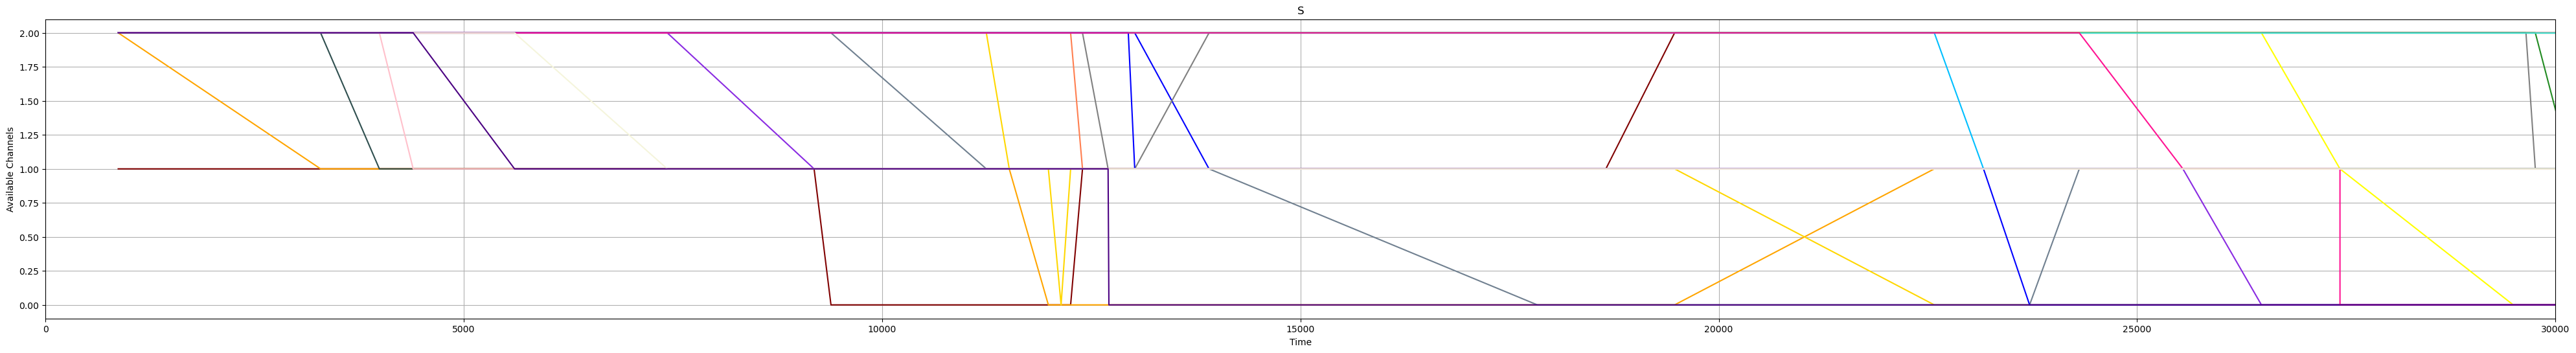

In [207]:
# Plot line graph
plt.close()
plt.figure(figsize=(50, 6))
cycol = ["b","gray","red","coral","maroon","orange","gold","yellow","green","forestgreen","turquoise","darkslategray","deepskyblue","slategray","blue","blueviolet","deeppink","pink","beige","indigo"]
for i in range(20):
    t = "station" + str(i)
    plt.plot(statsRecorder.history[0]["simClock"], statsRecorder.history[0][t], color=cycol[i])
plt.xlabel('Time')
plt.ylabel('Available Channels')
plt.title('S')
plt.grid(True)
plt.xlim(0, 30000)
plt.show()

In [208]:
statsRecorder.history[0]

,Event,Call,realTimeClock,simClock,warmup,reserved,blocked,dropped,completed,total,...,station10,station11,station12,station13,station14,station15,station16,station17,station18,station19
0,<class '__main__.CallInitiationEvent'>,1-2,0.000000,869.187753,0.0,0,0,0,0,1,...,2,2,2,2,2,2,2,2,2,2
1,<class '__main__.CallInitiationEvent'>,2-3,0.000000,3288.122890,0.0,0,0,0,0,1,...,2,2,2,2,2,2,2,2,2,2
2,<class '__main__.CallInitiationEvent'>,3-4,0.003001,3990.382457,0.0,0,0,0,0,2,...,2,1,2,2,2,2,2,2,2,2
3,<class '__main__.CallInitiationEvent'>,4-5,0.003001,4394.517626,0.0,0,0,0,0,3,...,2,1,2,2,2,2,2,1,2,2
4,<class '__main__.CallInitiationEvent'>,5-6,0.004000,5606.172649,0.0,0,0,0,0,4,...,2,1,2,2,2,2,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,<class '__main__.CallHandoverEvent'>,33-34,0.013002,47712.719435,0.0,0,6,8,22,40,...,2,2,0,2,0,2,1,1,0,1
62,<class '__main__.CallTerminationEvent'>,37-39,0.013002,47964.812408,0.0,0,6,8,23,40,...,2,2,0,2,0,2,1,1,0,1
63,<class '__main__.CallHandoverEvent'>,19-21,0.013002,48882.270977,0.0,0,6,8,23,40,...,2,1,1,2,0,2,1,1,0,1
64,<class '__main__.CallHandoverEvent'>,23-25,0.013002,48989.261894,0.0,0,6,8,23,40,...,2,1,1,2,0,2,1,1,0,1


In [209]:
statsRecorder.history[0].to_csv('result.csv')